# **Содержание**

Необходимо произвести предварительный анализ тарифов «Смарт» и «Ультра» компании «Мегалайн» на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Изучение данных из файла

- посмотрим наборы данных
- сделаем предварительные выводы
- поищем аномалии
- найти и обработать пропуски
- заменить некорректные типы данных
- привести данные к нужным типам

Импортируем все необходимые бибилиотеки

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns                #для создания красивых статистических графиков
from matplotlib import pyplot as plt

from scipy import stats as st

from datetime import datetime
import math as m

pd.options.display.float_format = '{:,.2f}'.format

Теперь прочтем данные из предоставленных датасетов

In [ ]:
#прочтем данные

df_calls = pd.read_csv('/datasets/calls.csv', sep=',')
df_internet = pd.read_csv('/datasets/internet.csv', sep=',')
df_msg = pd.read_csv('/datasets/messages.csv', sep=',')
df_tariffs = pd.read_csv('/datasets/tariffs.csv', sep=',')
df_users = pd.read_csv('/datasets/users.csv', sep=',')

## Предобработка данных

Для начала, приведём данные к нужным нам типам, а также найдем и исправим ошибки в данных.

**1. Изучим таблицу с информацией о пользователях**

In [ ]:
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [ ]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [ ]:
df_users.describe()

,user_id,age
count,500.00,500.00
mean,"1,249.50",46.59
std,144.48,16.67
min,"1,000.00",18.00
25%,"1,124.75",32.00
50%,"1,249.50",46.00
75%,"1,374.25",62.00
max,"1,499.00",75.00


Аномальных значений не выявлено: макисмальный возраст 75 лет, минимальный - 18. 

Мы видим, что колонки reg_date и churn_date имеют тип object, преобразуем их в даты

In [ ]:
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format="%Y-%m-%d")
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format="%Y-%m-%d")

#также, для экономии памяти, преобразуем столбцы user_id и age в тип int32
df_users['user_id'] = df_users['user_id'].apply(pd.to_numeric).astype('int32')
df_users['age'] = df_users['age'].apply(pd.to_numeric).astype('int32')

Проверим дубликаты по таблице users

In [ ]:
df_users.duplicated().sum()

0

**2. Посмотрим на информацию об интернет-сессиях**

In [ ]:
df_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,"1,052.81",2018-09-07,1000
2,2,1000_2,"1,197.26",2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [ ]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [ ]:
df_internet.describe()

,Unnamed: 0,mb_used,user_id
count,"149,396.00","149,396.00","149,396.00"
mean,"74,697.50",370.19,"1,252.10"
std,"43,127.05",278.30,144.05
min,0.00,0.00,"1,000.00"
25%,"37,348.75",138.19,"1,130.00"
50%,"74,697.50",348.01,"1,251.00"
75%,"112,046.25",559.55,"1,380.00"
max,"149,395.00","1,724.83","1,499.00"


Здесь мы видим задублированный столбец с индексами строк, удалим его.

In [ ]:
df_internet = df_internet.drop('Unnamed: 0', axis=1)

Так же мы заметили нулевое значение в столбце с трафиком. Изучим подробнее количество нулевых значений.

In [ ]:
df_internet.query('mb_used == 0.0').count().id

19598

In [ ]:
round(((df_internet
        .query('mb_used == 0')
        .groupby('user_id').count() / 
         df_internet.groupby('user_id')
        .count()) * 100)
        .sort_values(by='id', ascending=False)).id

user_id
1434   25.00
1041   24.00
1190   24.00
1351   23.00
1322   22.00
        ... 
1201    1.00
1309    1.00
1343     nan
1397     nan
1399     nan
Name: id, Length: 497, dtype: float64

In [ ]:
df_internet.query('mb_used == 0').id.count() / df_internet.shape[0]

0.13118155773916304

Избавимся от нулевых значений в выборке

In [ ]:
df_internet = df_internet[df_internet['mb_used'] != 0]

Преобразуем тип данных колонки session_date в дату

In [ ]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format="%Y-%m-%d")

#user_id и id преобразуем в int
df_internet['user_id'] = df_internet['user_id'].apply(pd.to_numeric).astype('int32')
df_internet['id'] = df_internet['id'].astype('int32')

Проверим данные по интернет трафику на дубликаты

In [ ]:
df_internet.duplicated().sum()

0

**3. Изучим информацию о сообщениях**

In [ ]:
df_msg.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [ ]:
df_msg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Также преобразуем даты в нормальный тип

In [ ]:
df_msg['message_date'] = pd.to_datetime(df_msg['message_date'], format="%Y-%m-%d")

#user_id и id преобразуем в int
df_msg['user_id'] = df_msg['user_id'].apply(pd.to_numeric).astype('int32')
df_msg['id'] = df_msg['id'].astype('int32')

In [ ]:
df_msg.describe()

,id,user_id
count,"123,036.00","123,036.00"
mean,"1,144,526.68","1,256.99"
std,"1,717,919.26",143.52
min,"10,000.00","1,000.00"
25%,"141,889.75","1,134.00"
50%,"1,158,504.50","1,271.00"
75%,"1,343,105.25","1,381.00"
max,"14,331,091.00","1,499.00"


In [ ]:
df_msg.duplicated().sum()

0

Пропусков не замечено, типы данных преобразованы

**4. Изучим данные с информацией о звонках** 

In [ ]:
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [ ]:
df_calls.info() #получим общее понимание набора данных для таблицы со звонками

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [ ]:
df_calls.describe()

,duration,user_id
count,"202,607.00","202,607.00"
mean,6.76,"1,253.94"
std,5.84,144.72
min,0.00,"1,000.00"
25%,1.30,"1,126.00"
50%,6.00,"1,260.00"
75%,10.70,"1,379.00"
max,38.00,"1,499.00"


Аномалий нет, пропусков также не выявлено.
Однако необходимо преобразовать тип данных колонки call_date и округлить значения колонки duration

In [ ]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format="%Y-%m-%d")

#user_id и id преобразуем в int
df_calls['user_id'] = df_calls['user_id'].apply(pd.to_numeric).astype('int32')
df_calls['id'] = df_calls['id'].astype('int32')

Мы видим значения 0.00 - считаем, что это пропущенные звонки и платы за это не взимается. 
Округлим все что больше нуля до целочисленных значений (т.е. так, как их округляет оператор)

Проверим долю звонков с длительностью 0 в общей массе звонков по клиенту, а так же общее количество таких звонков.

In [ ]:
round(((df_calls
        .query('duration == 0')
        .groupby('user_id').count() / 
         df_calls.groupby('user_id')
        .count()) * 100)
        .sort_values(by='id', ascending=False)).id

user_id
1257   50.00
1181   32.00
1398   30.00
1016   30.00
1373   29.00
        ... 
1286   13.00
1406   13.00
1103   12.00
1206   12.00
1084    9.00
Name: id, Length: 492, dtype: float64

In [ ]:
df_calls_zero = df_calls.query('duration == 0').id.count()
df_calls_zero

39613

In [ ]:
#посчитаем долю нулевых значений в выборке

df_rate_call_zero = df_calls_zero/202607*100
df_rate_call_zero

19.551644316336553

Мы наблюдаем большое количество нулевых значений по данным о длительности звонка. 
Так же мы наблюдаем большую долю таких звонков у каждого абонента. 
Это может объясняться рекламными звонками, или технической ошибкой в подсчете минут или чем-то другим: доля нулевых значений в выборке составляет почти 20%.

Для корректного проведения анализа мы отбросим данные с нулевыми значениями.

In [ ]:
df_calls = df_calls[df_calls['duration'] != 0]

In [ ]:
df_calls['duration'] = np.ceil(df_calls['duration']) #округлим числа до целых

In [ ]:
#теперь посмотрим, какую долю занимают пропущенные значения в каждом столбце
df_calls.isnull().sum().sort_values()/df_calls.shape[0]*100

id          0.00
call_date   0.00
duration    0.00
user_id     0.00
dtype: float64

Проверим таблицу на дубликаты

In [ ]:
df_calls.duplicated().sum()

0

**Посмотрим на таблицу с тарифами**

In [ ]:
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Переименуем колонку с тарифами

In [ ]:
df_tariffs = df_tariffs.rename(columns={'tariff_name':'tariff'})

In [ ]:
df_tariffs.info() #получим общее понимание набора данных для таблицы с тарифами

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff                   2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Ожидаемо, что в таблице с тарифами и не должно быть каких-либо ошибок, аномалий или пропусков

### Вывод

Мы предварительно просмотрели данные на наличие аномалий, пропусков и нулевых значений.
Длительность звонков боле 0.00 мы округлили до целых значений в большую сторону.

В процессе предобработки данных, мы выявили значительную массу звонков с нулевой длительностью. Мы избавились от таких значений во избежание искажения результатов анализа.

То же самое мы обнаружили и с данными об использовании интернет трафика, большая доля нулевых значений, возможно причина в нарушениях процесса хранения данных.

## Подготовка данных

Посчитаем для каждого пользователя:
 - количество сделанных звонков и израсходованных минут разговора по месяцам;
 - количество отправленных сообщений по месяцам;
 - объем израсходованного интернет-трафика по месяцам;
 - помесячную выручку с каждого пользователя

**Посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам**

In [ ]:
df_calls.head(5)

,id,call_date,duration,user_id
2,10002,2018-06-11,3.00,1000
3,10003,2018-09-21,14.00,1000
4,10004,2018-12-15,6.00,1000
7,10007,2018-08-22,19.00,1000
8,10008,2018-09-15,19.00,1000


Добавим в таблицу столбец с месяцем и количеством сделанных звонков, сгруппируем по user_id и duration

In [ ]:
df_calls['month'] = df_calls['call_date'].dt.month_name()

In [ ]:
user_calls = df_calls.groupby(['user_id', 'month'])\
                  .agg({'duration':'sum', 'id':'count'})\
                  .reset_index()\
                  .rename(columns={'duration':'month_calls_duration','id':'calls_total_in_month'})

In [ ]:
user_calls.head()

,user_id,month,month_calls_duration,calls_total_in_month
0,1000,August,408.00,42
1,1000,December,333.00,38
2,1000,July,340.00,41
3,1000,June,172.00,28
4,1000,May,159.00,17


**По аналогии сгруппируем таблицу с сообщениями, чтобы узнать кол-во отправленных сообщений по месяцам.**

In [ ]:
df_msg.sample(5)

,id,message_date,user_id
46774,1203159,2018-09-10,1203
92846,1382307,2018-12-23,1382
85782,1356799,2018-06-08,1356
9446,1039102,2018-10-16,1039
14679,106515,2018-03-24,1065


In [ ]:
df_msg['month'] = df_msg['message_date'].dt.month_name()

In [ ]:
user_messages = df_msg.groupby(['user_id', 'month'])\
                        .agg({'id':'count'})\
                        .reset_index()\
                        .rename(columns={'id':'sms_total_in_month'})

user_messages.head()

,user_id,month,sms_total_in_month
0,1000,August,81
1,1000,December,70
2,1000,July,75
3,1000,June,60
4,1000,May,22


**Теперь найдем объем израсходованного интернет-трафика по месяцам**

In [ ]:
df_internet.sample(5)

,id,mb_used,session_date,user_id
77368,126220,887.66,2018-09-16,1262
38433,1134488,525.79,2018-03-02,1134
42083,114739,397.96,2018-09-05,1147
14560,1051174,731.60,2018-06-24,1051
108324,1370129,386.18,2018-08-23,1370


In [ ]:
#преобразуем  колонку session_date в месяц

df_internet['month'] = df_internet['session_date'].dt.month_name()

Сгруппируем данные по интернету по пользователям в разрезе месяцев

In [ ]:
user_internet = df_internet.groupby(['user_id', 'month'])\
                        .agg({'mb_used':'sum'})\
                        .reset_index()\
                        .rename(columns={'mb_used':'mb_total_in_month'})

In [ ]:
user_internet.head()

,user_id,month,mb_total_in_month
0,1000,August,"14,055.93"
1,1000,December,"9,817.61"
2,1000,July,"14,003.64"
3,1000,June,"23,233.77"
4,1000,May,"2,253.49"


**Теперь посчитаем помесячную выручку с каждого пользователя.**
Для этой цели, объединим все таблицы (по звонкам, смс и интернету) в одну с помощью метода merge.

Объединим таблицы user_messages с user_calls, в качестве ключа будем использовать user_id и month, метод объединения - outer.
Метод outer включает все строки, которые совпали по заданным колонкам.

In [ ]:
df = user_calls.merge(user_messages, on=['user_id','month'], how='outer')

Далее, объединим полученные данные с таблицей user_internet

In [ ]:
df = df.merge(user_internet, on=['user_id','month'], how = 'outer')

На данный момент мы получили таблицу, содержащую данные по звонкам, использованию интернета и сообщениям.
Дополним ее данными о самих пользователях и информацией о тарифных планах

In [ ]:
df = df.merge(df_users, on='user_id', how='left')

In [ ]:
df = df.merge(df_tariffs, on='tariff', how='left')
df.head()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,August,408.00,42.00,81.00,"14,055.93",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,December,333.00,38.00,70.00,"9,817.61",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,July,340.00,41.00,75.00,"14,003.64",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,June,172.00,28.00,60.00,"23,233.77",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,May,159.00,17.00,22.00,"2,253.49",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


Рассмотрим пропущенные значения

In [ ]:
df.isna().sum()

user_id                     0
month                       0
month_calls_duration       46
calls_total_in_month       46
sms_total_in_month        497
mb_total_in_month          13
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

Порядка 500 человек не пользуются SMS, еще 13 - не пользуются интернетом. Проставим им нули, это не сильно изменит общую картину данных.

In [ ]:
df['sms_total_in_month'] = df['sms_total_in_month'].fillna(0)
df['mb_total_in_month'] = df['mb_total_in_month'].fillna(0)
df['month_calls_duration'] = df['month_calls_duration'].fillna(0)
df['calls_total_in_month'] = df['calls_total_in_month'].fillna(0)

<div class="alert alert-success">
<b>Комментарий ревьюера v1:</b>

Тут все верно.
</div>

In [ ]:
df.isna().sum()

user_id                     0
month                       0
month_calls_duration        0
calls_total_in_month        0
sms_total_in_month          0
mb_total_in_month           0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

Напишем функцию, которая будет округлять значения и расчитает выручку по каждому пользователю без абонентской платы

In [ ]:
def above_the_tariff(row):
    sms = (row['sms_total_in_month'] - row['messages_included']) * row['rub_per_message'] #вычтем бесплатный лимит из суммарного количества сообщений и умножим на значение из тарифного плана 
    mins = (row['month_calls_duration'] - row['minutes_included']) * row['rub_per_minute'] #вычтем бесплатный лимит из суммарного количества звонков и умножим на значение из тарифного плана 
    mbs = np.ceil((row['mb_total_in_month'] - row['mb_per_month_included']) * row['rub_per_gb'] / 1024) 
    total = 0
    for i in [sms, mins, mbs]:
        if i > 0:
            total += i
    return total

In [ ]:
df.head()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,above_the_tariff,total_revenue,region
0,1000,August,408.00,42.00,81.00,"14,055.93",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.00,"1,950.00",Провинция
1,1000,December,333.00,38.00,70.00,"9,817.61",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.00,"1,950.00",Провинция
2,1000,July,340.00,41.00,75.00,"14,003.64",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.00,"1,950.00",Провинция
3,1000,June,172.00,28.00,60.00,"23,233.77",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.00,"1,950.00",Провинция
4,1000,May,159.00,17.00,22.00,"2,253.49",52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,0.00,"1,950.00",Провинция


In [ ]:
df['above_the_tariff'] = df.apply(lambda x: above_the_tariff(x), axis=1)

Расчитаем столбец с общим доходом на каждого пользователя, назовем его total_revenue

In [ ]:
df['total_revenue'] = df['rub_monthly_fee'] + df['above_the_tariff']

In [ ]:
#Отсортируем значения по доходу от меньшего к большему
pd.set_option('display.max_columns', None)
df.sort_values(by='total_revenue').head()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,above_the_tariff,total_revenue,region
1230,1193,October,459.00,58.00,29.00,"10,051.86",55,NaT,Тамбов,Арсен,Безруков,2018-01-01,smart,50,15360,500,550,200,3,3,0.00,550.00,Провинция
1290,1204,December,416.00,45.00,0.00,"23,259.55",18,NaT,Москва,Мирослава,Лазарева,2018-01-04,smart,50,15360,500,550,200,3,3,0.00,550.00,Москва
1289,1204,August,486.00,51.00,0.00,"20,821.89",18,NaT,Москва,Мирослава,Лазарева,2018-01-04,smart,50,15360,500,550,200,3,3,0.00,550.00,Москва
1288,1204,April,268.00,30.00,0.00,"18,664.81",18,NaT,Москва,Мирослава,Лазарева,2018-01-04,smart,50,15360,500,550,200,3,3,0.00,550.00,Москва
2531,1401,December,351.00,40.00,49.00,"11,787.27",42,NaT,Москва,Владислава,Васильева,2018-01-24,smart,50,15360,500,550,200,3,3,0.00,550.00,Москва


### Вывод

Данные по доходам от каждого пользователя получены.
 - минимальное значение - это ежемесячное пополнение по тарифу smart
 - в среднем абоненты платят от 1480 до 1550 руб в месяц. Пока можно предположить, что возможно абоненты тарифа smart зачастую переплачивают сверх абонентской платы.
 
 Мы подготовили данные к анализу:

Округлили значения столбцов длительность звонка и размер интернет трафика до целого значения вверх;

Посчитали каждый показатель в разрезе юзер - месяц;

Свели все данные в одну таблицу;

Посчитали выручку по каждому юзеру;

## Анализ данных

На данном этапе нам необходимо сделать следующее:
 - Посчитать, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц 
 - Посчитать среднее количество, дисперсию и стандартное отклонение, построить гистограммы и описать распределение.

Построим гистограммы, отражающие оплату абонентами тарифов smart и ultra

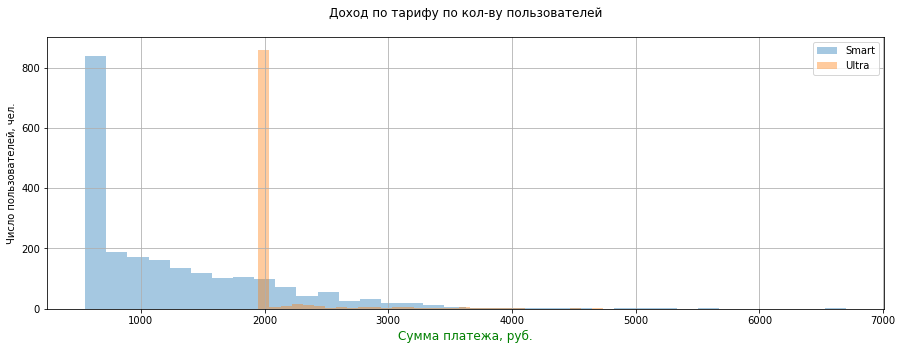

In [ ]:
fig, ax = plt.subplots()

fig.set_size_inches(15, 5) #Установим размер графика

sns.distplot(df[df['tariff'] == 'smart']['total_revenue'], hist=True, kde=False, label='Smart')
sns.distplot(df[df['tariff'] == 'ultra']['total_revenue'], hist=True, kde=False, label='Ultra')
ax.grid(True) #добавим сетку

#  Добавляем подписи к осям:
ax.set_xlabel('Сумма платежа, руб.',
        fontsize = 12,    #  размер шрифта
        color = 'green')    #  цвет шрифта
ax.set_ylabel('Число пользователей, чел.')

ax.set_title(r'Доход по тарифу по кол-ву пользователей', pad = 20) #добавим название графику

plt.legend()
plt.show()

Построим пивот таблицу с расчитанными значениями по медиане, средней, дисперсию и стандартное отклонение

In [ ]:
pivot_table_revenue = pd.pivot_table(df, 
                       values='total_revenue', 
                       index='tariff',
                       aggfunc={'total_revenue': ['median','mean','var','std']})
pivot_table_revenue

,mean,median,std,var
tariff,,,,
smart,"1,230.74",958.00,785.87,"617,599.00"
ultra,"2,059.94","1,950.00",355.01,"126,033.25"


По смарту переплачивают сверх тарифа, по ультра - нет, в пределах тарифа.

Теперь построим гистограммы, отражающие длительность звонков в минутах в зависимости от тарифного плана

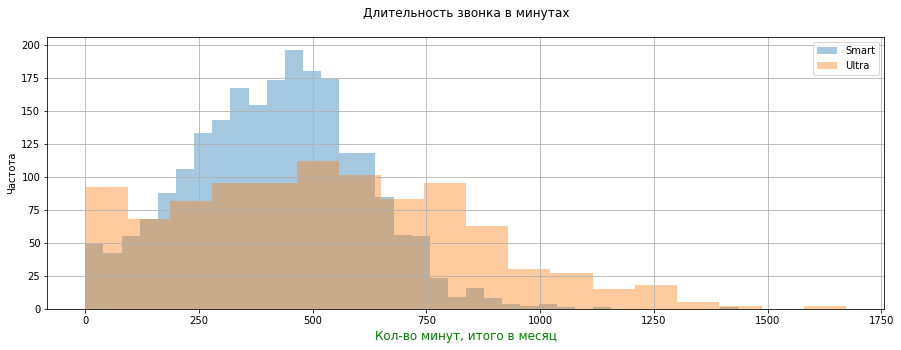

In [ ]:
fig, ax = plt.subplots()

fig.set_size_inches(15, 5) #Установим размер графика

sns.distplot(df[df['tariff'] == 'smart']['month_calls_duration'], hist=True, kde=False, label='Smart')
sns.distplot(df[df['tariff'] == 'ultra']['month_calls_duration'], hist=True, kde=False, label='Ultra')
ax.grid(True) #добавим сетку

#  Добавляем подписи к осям:
ax.set_xlabel('Кол-во минут, итого в месяц',
        fontsize = 12,    #  размер шрифта
        color = 'green')    #  цвет шрифта
ax.set_ylabel('Частота')

ax.set_title(r'Длительность звонка в минутах', pad = 20) #добавим название графику

plt.legend()
plt.show()

In [ ]:
pivot_table_calls_duration = pd.pivot_table(df, 
                       values='month_calls_duration', 
                       index='tariff',
                       aggfunc={'month_calls_duration': ['median','mean','var','std']})
pivot_table_calls_duration

,mean,median,std,var
tariff,,,,
smart,417.93,422.00,190.31,"36,219.32"
ultra,526.62,518.00,317.61,"100,873.63"


На тарифе Smart люди в месяц говорят около 420 минут, на Ultra 520 минут в месяц. 
Видимо, на кол-ва минут на тарифе Смарт абонентам не всегда достаточно. 
В свою очередь, на тарифе Ультра у пользователей остается запас порядка 2700 минут.

Взглянем на графики, отражающие использование интернета абонентами тарифа smart и ultra

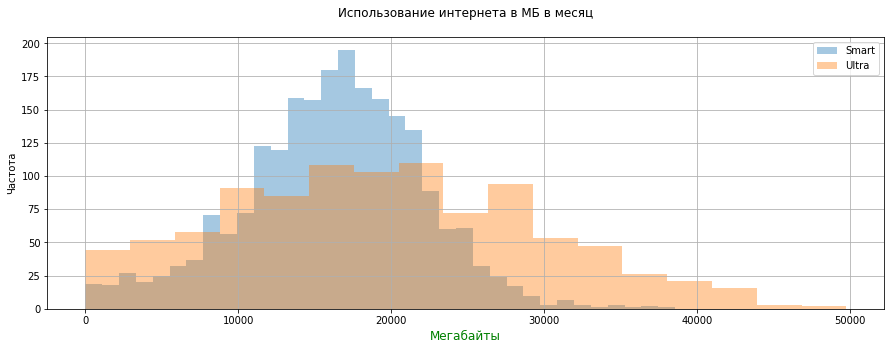

In [ ]:
fig, ax = plt.subplots()

fig.set_size_inches(15, 5) #Установим размер графика

sns.distplot(df[df['tariff'] == 'smart']['mb_total_in_month'], hist=True, kde=False, label='Smart')
sns.distplot(df[df['tariff'] == 'ultra']['mb_total_in_month'], hist=True, kde=False, label='Ultra')
ax.grid(True) #добавим сетку

#  Добавляем подписи к осям:
ax.set_xlabel('Мегабайты',
        fontsize = 12,    #  размер шрифта
        color = 'green')    #  цвет шрифта
ax.set_ylabel('Частота')

ax.set_title(r'Использование интернета в МБ в месяц', pad = 20) #добавим название графику

plt.legend()
plt.show()

In [ ]:
pivot_table_mb_in_month = pd.pivot_table(df, 
                       values='mb_total_in_month', 
                       index='tariff',
                       aggfunc={'mb_total_in_month': ['median','mean','var','std']})
pivot_table_mb_in_month

,mean,median,std,var
tariff,,,,
smart,"16,208.39","16,506.84","5,870.48","34,462,496.46"
ultra,"19,468.81","19,308.01","10,087.17","101,751,013.78"


Средние и медианные значения лежат рядом на обоих тарифах. 
На тарифе Smart люди выходят за пределы тарифа больше, у Ультры снова запас — около 10 Гб.

Проанализируем графики по использованию SMS абонентами на разных тарифах

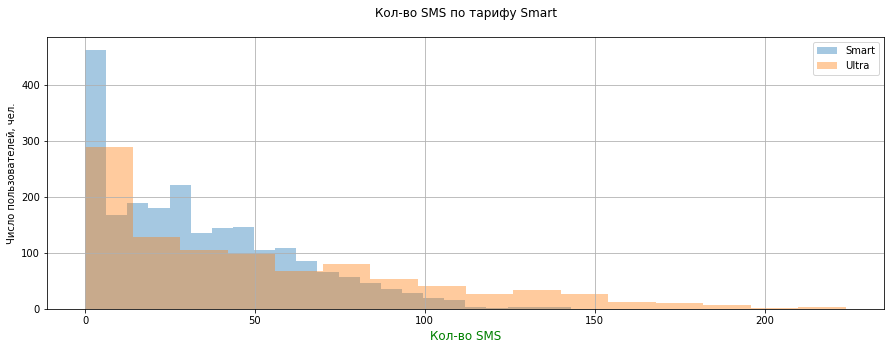

In [ ]:
fig, ax = plt.subplots()

fig.set_size_inches(15, 5) #Установим размер графика

sns.distplot(df[df['tariff'] == 'smart']['sms_total_in_month'], hist=True, kde=False, label='Smart')
sns.distplot(df[df['tariff'] == 'ultra']['sms_total_in_month'], hist=True, kde=False, label='Ultra')

ax.grid(True) #добавим сетку

#  Добавляем подписи к осям:
ax.set_xlabel('Кол-во SMS',
        fontsize = 12,    #  размер шрифта
        color = 'green')    #  цвет шрифта
ax.set_ylabel('Число пользователей, чел.')

ax.set_title(r'Кол-во SMS по тарифу Smart', pad = 20) #добавим название графику

plt.legend()
plt.show()

In [ ]:
pivot_table_sms = pd.pivot_table(df, 
                       values='sms_total_in_month', 
                       index='tariff',
                       aggfunc={'sms_total_in_month': ['median','mean','var','std']})
pivot_table_sms

,mean,median,std,var
tariff,,,,
smart,33.38,28.00,28.23,796.81
ultra,49.36,38.00,47.80,"2,285.27"


Поведение абонентов таково, что они крайне мало используют SMS, особенно на тарифе Ultra.
Можно сказать что у пользователей обоих тарифов  - SMS-сообщения не востребованная функция.

Посчитаем общую выручку по каждому тарифу

In [ ]:
df[df['tariff'] == 'smart']['total_revenue'].sum()

2743322.0

In [ ]:
df[df['tariff'] == 'ultra']['total_revenue'].sum()

2029037.0

### Вывод

Больше всего выручки компании приносит тариф Смарт, почти на 700 млн.руб. Однако по данному тарифу пользователям не всегда хватает стандартного пакета, в отличие от тарифа Ультра. 

## Проверка гипотез

Проверим следующие гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

Пороговое значение alpha мы будем использовать как 0.05 (5%). 
Это стандартная величина отклонения, используемая для статистических тестов.

In [ ]:
# Для начала, напишем функцию для удаления выбросов

def delete_outliers(df, column, graphic=0, x=10, y=10):
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1                                                                    # расчитаем интерквартильный размах
    net_settlement = (df[column] >= (q1 - 1.5*iqr)) & (df[column] <= (q3 + 1.5*iqr)) # произведем расчет,очищенный от выбросов
    if graphic == 1:
        return df.loc[net_settlement].boxplot([column], figsize=(x,y))
    else:
        return df.loc[net_settlement]

Будем использовать t-критерий Стьюдента, так как сравниваемые выборки независимы между собой.

**Гипотеза о равенстве средних двух генеральных совокупностей №1**

**Сформулируем гипотезы:**

- H0: выручка пользователей тарифов «Ультра» и «Смарт» не различается
- H1: выручка пользователей тарифов «Ультра» и «Смарт» различается

In [ ]:
ultra = df[df['tariff'] == 'ultra']
smart = df[df['tariff'] == 'smart']

In [ ]:
ultra = delete_outliers(ultra, 'total_revenue', 0)
ultra = ultra['total_revenue']

In [ ]:
smart = delete_outliers(smart, 'total_revenue', 0)
smart = smart['total_revenue']

In [ ]:
alpha = 0.05

In [ ]:
results = st.ttest_ind(ultra, smart)

In [ ]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 7.855133009292105e-203
Отвергаем нулевую гипотезу


По наблюдаемым данным можно сделать вывод, что, скорее всего, наша нулевая гипотеза неверна, соответственно принимаем гипотезу №1. Соответственно, делаем вывод что выручка пользователей тарифов «Ультра» и «Смарт» различается


**Гипотеза о равенстве средних двух генеральных совокупностей №2**

**Сформулируем гипотезы:**

- H0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
- H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [ ]:
df['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Курган', 'Барнаул', 'Красноярск', 'Архангельск', 'Липецк',
       'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Волжский', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [ ]:
df['region'] = np.where(df['city'] == 'Москва', 'Москва', 'Провинция')

In [ ]:
moscow = df[df['region'] == 'Москва']
province = df[df['region'] == 'Провинция']

In [ ]:
moscow = delete_outliers(moscow, 'total_revenue', 0)
moscow = moscow['total_revenue']

In [ ]:
province = delete_outliers(province, 'total_revenue', 0)
province = province['total_revenue']

In [ ]:
results = st.ttest_ind(moscow, province)
# equal_var = False

In [ ]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.27741835756809463
Не получилось отвергнуть нулевую гипотезу


С вероятностью в 27% такой результат может быть получен случайно. Значимых различий нет.

## Общий вывод

 - Абоненты на разных тарифах ведут себя по-разному. На тарифе Смарт абонентам не всегда хватает пакета минут и интернета и им приходится доплачивать, что может отрицательно влиять на их лояльность. В свою очередь, на тарифе Ультра пользователи не используют все лимиты, и по сути переплачивают. Возможность, есть смысл увеличить лимиты на одном тарифе, и уменьшить на другом, оставив стоимость без изменения.

- На обоих тарифах СМС не востребованы, особенно на тарифе Ultra. Очевидно, ользователи тарифа ultra приобритают его ради интернета, т.к. нужный им объем трафика обходится дешевле на этом тарифе в разы. Но при этом они используют пакет смс и звонков всего на треть. Необходимо подумать, как использовать данную упущенную выгоду. Возможно, необходимо уменьшить лимит СМС и уменьшить стоимость тарифа, т.к. абоненты по сути переплачивают за неиспользованные лимиты.

- Выручка сильно не различается между Москвой и регионами. Значит, это не связано с уровнем жизни, а скорее с общим поведением: ~8-10 часов в месяц — это предел у среднего клиента на обоих тарифах

- Выручка по абонентам на разных тарифах различается. Тариф Смарт приносит больше выручки, чем Ультра. Однако его необходимо переработать, т.к. абоненты часто переплачивают по нему.

**Отвечая на главный вопрос**
Пользователи smart тарифа в половине случаев превышают предоставленный им пакет услуг по всем трем видам и приносят дополнительный доход. Но при этом средняя выручка на пользователя в месяц остается сильно ниже стоимости тарифа ultra (на одного абонента тариф ультра приносит в среднем больше выручки).


Рекомендации:
- Вероятно для максимизации прибыли стоит немного увеличить стоимость интернета в обоих тарифах, при этом немного сократив объем пакета для интернета.
- Если увеличить кол-во пользователей тарифа Ультра и уменьшить его стоимость, то это поспособствует увеличению выручки

Также, необходимо добавить округленые значения использованных минут и МБ интернета

В целом, необходимо задуматься над оптимизацией тарифов.